In [14]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

amzn_stock = yf.download('AMZN', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
amzn_stock.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2010-01-04,6.6950,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6760,6.6840,6.4515,6.5280,196610000


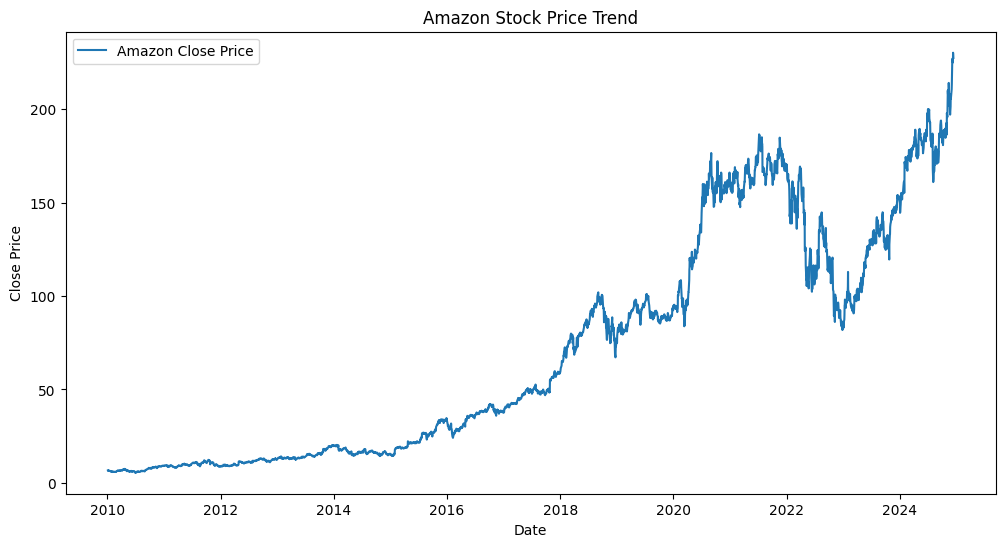

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(amzn_stock['Close'], label='Amazon Close Price')
plt.title('Amazon Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [5]:
# Set Date as index if not already
if 'Date' not in amzn_stock.columns:
    amzn_stock['Date'] = amzn_stock.index
amzn_stock.set_index('Date', inplace=True)

aapl_prices = amzn_stock['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)
joblib.dump(scaler, "amazon_scaler_5.joblib")  # Save the fitted scaler


# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length - 5 + 1):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length:i + seq_length + 5])

    return np.array(sequences), np.array(labels)

seq_length = 100
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(5))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,005 (125.02 KB)

 Trainable params: 32,005 (125.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Early stopping to prevent overfitting and stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Model checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model_5.keras',  # Filepath to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only when the model is the best
    verbose=1                      # Print saving info
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor validation loss
    factor=0.5,                    # Reduce learning rate by a factor of 0.5
    patience=5,                    # Number of epochs with no improvement before reducing
    min_lr=1e-6,                   # Minimum learning rate
    verbose=1                      # Print learning rate reduction info
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]


In [8]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=8, 
    epochs=60, 
    validation_data=(X_test, y_test), 
    callbacks=callbacks  # Include callbacks in training
)


Epoch 1/60
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0091
Epoch 1: val_loss improved from inf to 0.00195, saving model to best_lstm_model_5.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0091 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/60
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.3479e-04
Epoch 2: val_loss improved from 0.00195 to 0.00157, saving model to best_lstm_model_5.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 3.3477e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 3/60
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8728e-04
Epoch 3: val_loss did not improve from 0.00157
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 3.8720e-04 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 4/60
363/364 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.2668e-04
Epoch 4: val_loss improved from 0.00157 to 0.00113, saving model to best_lstm_model_5.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 3.2666e-04 - val_loss: 0.0011 - lea

In [9]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [11]:
# Evaluate model performance
y_test_reshaped = y_test.squeeze()

def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test_reshaped, predictions)

RMSE: 145.2742491437984, MAE: 141.1845678275364, R2: -845559.654575784


[*********************100%***********************]  1 of 1 completed

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


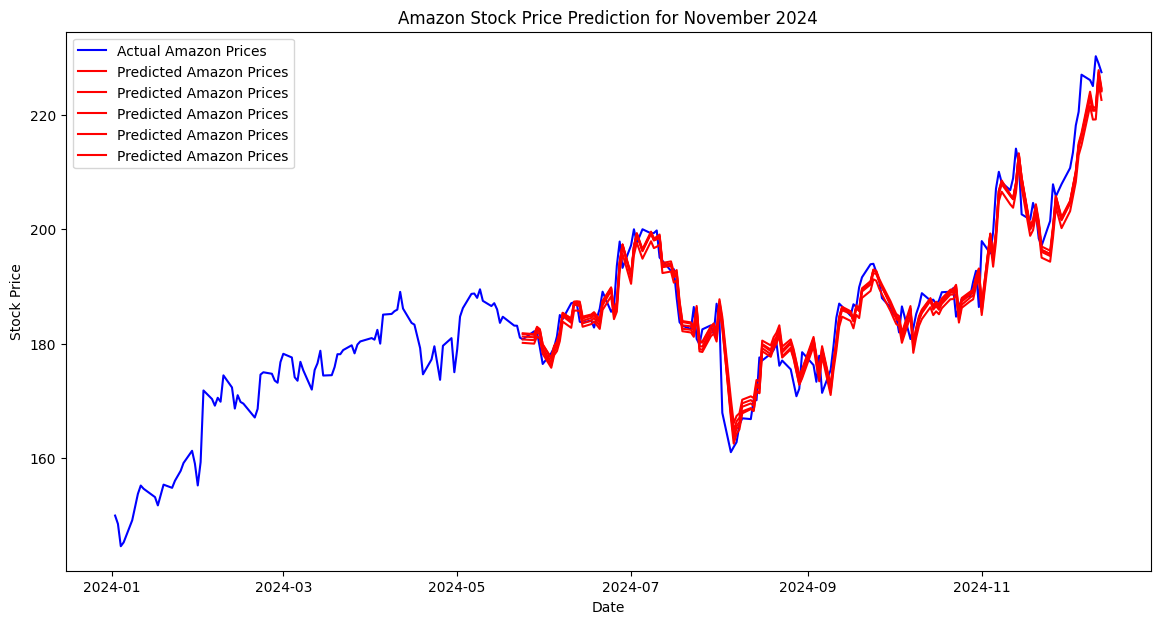

In [12]:
# Fetch data from Yahoo Finance
end_date = datetime.now().strftime('%Y-%m-%d')

aapl = yf.download("AMZN", start="2024-01-01", end=end_date)
aapl['Date'] = aapl.index
aapl_prices = aapl['Close'].values.reshape(-1, 1)

# Scale the data using the same scaler
# scaler = MinMaxScaler()
aapl_prices_scaled = scaler.transform(aapl_prices)

# Create sequences for prediction
seq_length = 100
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_future = create_sequences(aapl_prices_scaled, seq_length)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Plot real vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(aapl['Date'], aapl['Close'], label="Actual Amazon Prices", color='blue')
plt.plot(aapl['Date'][seq_length:], predictions_rescaled, label="Predicted Amazon Prices", color='red')
plt.title("Amazon Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


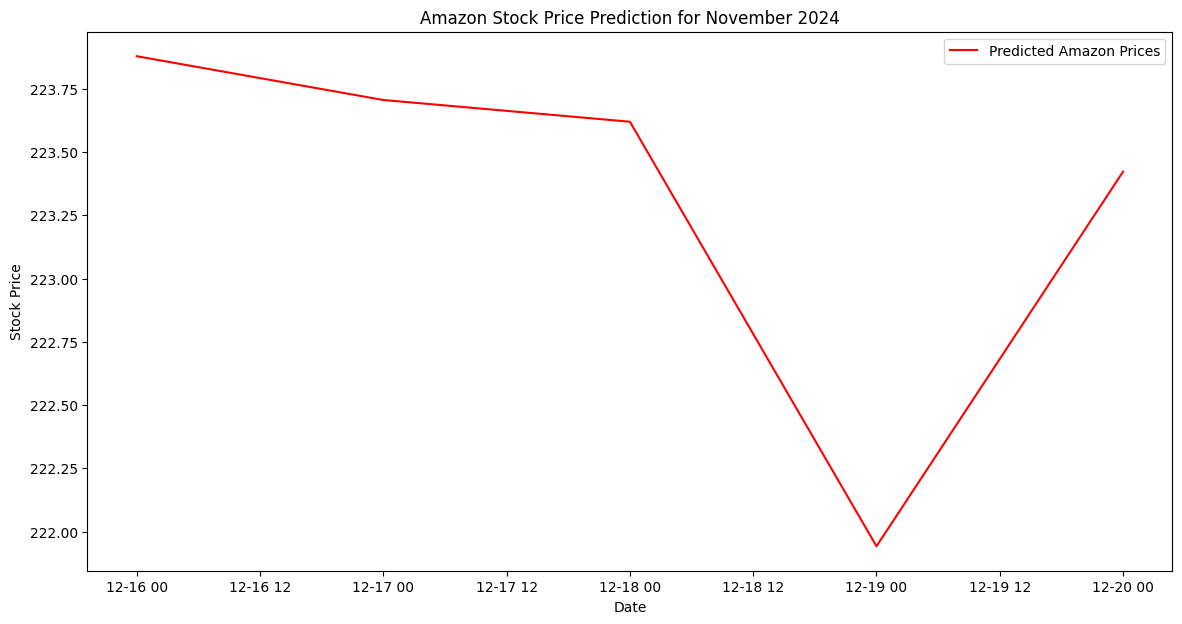

In [17]:
seq_length=100
# Prepare future prediction sequence
X_future = aapl_prices_scaled[-seq_length:].reshape(1, seq_length, 1)

# Predict November 2024 stock prices
predictions = model.predict(X_future)
predictions_rescaled = scaler.inverse_transform(predictions)

# Generate future dates for plotting
# future_dates = pd.date_range(start=datetime.now().strftime('%Y-%m-%d'), periods=11, freq='B')[1:]  # Exclude last known date

# Generate future dates from 14-12-2024 to 24-12-2024
s_date = datetime.now().strftime('%Y-%m-%d')
future_dates = pd.date_range(start=s_date, end="2024-12-21", freq='B')



# Plot the real vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(future_dates, predictions_rescaled.flatten(), label="Predicted Amazon Prices", color='red')  # Predicted
plt.title("Amazon Stock Price Prediction for November 2024")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()